In [17]:
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import csv
#import pyflux as pf
from datetime import datetime
#!pip install pyflux
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import torch

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
def prepare_data(df_train, df_test, window_size):
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(df_train)  # fit only on training data 

    df_train = scaler.transform(df_train)  # Use transform instead of fit_transform
    df_test = scaler.transform(df_test)  # Use transform instead of fit_transform

    # Prepare the data
    supervised_train_data = series_to_supervised(df_train, n_in=window_size, n_out=1, autoregressive=True)
    supervised_test_data = series_to_supervised(df_test, n_in=window_size, n_out=1, autoregressive=True)
    
    X_train_np = supervised_train_data.iloc[:, :-2].values  # All features except the last two columns
    y_train_np = supervised_train_data.iloc[:, -2:].values  # Only the last two columns
    X_test_np = supervised_test_data.iloc[:, :-2].values
    y_test_np = supervised_test_data.iloc[:, -2:].values

    # Reshape to 3D tensors (batch_size, seq_len, input_size)
    X_train = np.expand_dims(X_train_np, axis=2)
    y_train = np.expand_dims(y_train_np, axis=2)
    X_test = np.expand_dims(X_test_np, axis=2)
    y_test = np.expand_dims(y_test_np, axis=2)

    # Convert to PyTorch tensors
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # Create PyTorch datasets
    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    return train_dataset, test_dataset, X_train_np,y_train_np,X_test_np,y_test_np,scaler


def create_dataloaders(train_dataset, test_dataset, batch_size):
    # DataLoaders for batching and shuffling the data
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader


def train_lstm_model(model, train_loader, val_loader, input_size, hidden_size, output_size, num_epochs):
    # Create the LSTM model
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            
            X_batch, y_batch = X_batch.to('cuda'), y_batch.to('cuda')

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()

        # Optionally, you can add validation loop here

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}")

    return model

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, autoregressive=True):
    no_autoregressive = not(autoregressive)
    if no_autoregressive:
        n_in = n_in - 1

    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        if no_autoregressive:
            cols.append(df.shift(i).iloc[:,:-1])
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars-1)]
        else:
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x is 1585,12,1
        output, _ = self.lstm(x) # 1585,12,128
        output = self.fc(output[:,-2:,:]) # 1585,2,1
        return output

def create_lstm_model(input_size, hidden_size, output_size):
    model = LSTMModel(input_size, hidden_size, output_size)
    return model

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

def predict_lstm(model, X_test,device):
    # Change dimension
    X_test = np.expand_dims(np.array(X_test), 2)

    # Convert the data to PyTorch tensors and move to the appropriate device
    X_test = torch.from_numpy(X_test).float().to(device)  # Ensure to place X_test on the same device as the model

    # Predict the CPU values for the testing data
    outputs = model(X_test)
    y_pred = outputs.detach().cpu().numpy()  # Move back to CPU and convert to numpy

    return y_pred

def evaluate_predictions(y_true, y_pred):
    # Calculate the Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Calculate the Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate the Mean Absolute Percentage Error (MAPE)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    return mse, mae, mape, rmse

In [19]:
df_mem = pd.read_csv("../Grafana_data/Memory_usage_7_days.csv")
df_cpu = pd.read_csv("../Grafana_data/CPU_data_7_days.csv")

# Dropping unnecessary columns
df_cpu.drop(columns=['host_name', 'http_scheme', 'icos_agent_id', 'icos_controller_id',
       'icos_host_id', 'icos_host_name', 'instance', 'job', 'net_host_name',
       'net_host_port', 'receive', 'service_instance_id', 'service_name',
       'tenant_id', 'k8s_cluster_uid', 'k8s_container_name',
       'k8s_daemonset_name', 'k8s_namespace_name', 'k8s_node_name',
       'k8s_pod_name', 'k8s_pod_uid', 'Value'], inplace=True,axis=1)
df_mem.drop(columns=['host_name', 'http_scheme', 'icos_agent_id', 'icos_controller_id',
       'icos_host_id', 'icos_host_name', 'instance', 'job', 'net_host_name',
       'net_host_port', 'receive', 'service_instance_id', 'service_name',
       'tenant_id', 'k8s_cluster_uid', 'k8s_container_name',
       'k8s_daemonset_name', 'k8s_namespace_name', 'k8s_node_name',
       'k8s_pod_name', 'k8s_pod_uid', 'Value'], inplace=True,axis=1)

# Dealing with missing values
df_mem = df_mem.replace(to_replace='undefined', value=0)
df_cpu = df_cpu.replace(to_replace='undefined', value=0)

# Changing timestamp to minutes
df_cpu['timestamp'] = pd.to_datetime(df_cpu['Time'], unit='ms')
df_mem['timestamp'] = pd.to_datetime(df_mem['Time'], unit='ms')

# select column
col_num = 3

df_cpu_node3 = df_cpu[['timestamp',df_cpu.columns[col_num]]]
cols = {
    'timestamp': "timestamp",
    df_cpu.columns[col_num]:"CPU"
}
df_cpu_node3 = df_cpu_node3.rename(columns=cols, inplace=False)
df_mem_node3 = df_mem[['timestamp',df_mem.columns[col_num]]]
cols = {
    'timestamp': "timestamp",
    df_mem.columns[col_num]:"MEM"
}
df_mem_node3 = df_mem_node3.rename(columns=cols, inplace=False)

# Convert data from object to float
df_cpu_node3['CPU'] = df_cpu_node3['CPU'].astype(str).astype(float)
df_mem_node3['MEM'] = df_mem_node3['MEM'].astype(str).astype(float)

# Setting the 'Datetime' column as the index of the DataFrame
df_cpu_node3 = df_cpu_node3.set_index('timestamp')

# Ensuring that the index is of datetime type
df_cpu_node3.index = pd.to_datetime(df_cpu_node3.index)


df_mem_node3 = df_mem_node3.set_index('timestamp')

# Ensuring that the index is of datetime type
df_mem_node3.index = pd.to_datetime(df_mem_node3.index)

df_node3 = df_cpu_node3.join(df_mem_node3, how='outer')
df_node3 = df_node3.dropna()

#creating the train and validation set
df_train = df_node3[:int(0.8*(len(df_node3)))]
df_test = df_node3[int(0.8*(len(df_node3))):]
print(df_train.shape, df_test.shape)

(1591, 2) (398, 2)


In [20]:
window_size = 6
hidden_size = 64
num_epochs = 500
batch_size=64

input_size = 1
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
teacher_model = create_lstm_model(input_size, hidden_size, output_size)

train_dataset, test_dataset, X_train, y_train, X_test, y_test,scaler = prepare_data(df_train, df_test, window_size=window_size)

train_loader, val_loader = create_dataloaders(train_dataset, test_dataset, batch_size=batch_size)

teacher_model_trained = train_lstm_model(teacher_model, train_loader, val_loader, input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_epochs=num_epochs)

Epoch [1/500], Train Loss: 0.1648
Epoch [2/500], Train Loss: 0.0323
Epoch [3/500], Train Loss: 0.0259
Epoch [4/500], Train Loss: 0.0236
Epoch [5/500], Train Loss: 0.0207
Epoch [6/500], Train Loss: 0.0172
Epoch [7/500], Train Loss: 0.0159
Epoch [8/500], Train Loss: 0.0156
Epoch [9/500], Train Loss: 0.0155
Epoch [10/500], Train Loss: 0.0152
Epoch [11/500], Train Loss: 0.0153
Epoch [12/500], Train Loss: 0.0150
Epoch [13/500], Train Loss: 0.0148
Epoch [14/500], Train Loss: 0.0147
Epoch [15/500], Train Loss: 0.0146
Epoch [16/500], Train Loss: 0.0145
Epoch [17/500], Train Loss: 0.0141
Epoch [18/500], Train Loss: 0.0142
Epoch [19/500], Train Loss: 0.0135
Epoch [20/500], Train Loss: 0.0119
Epoch [21/500], Train Loss: 0.0102
Epoch [22/500], Train Loss: 0.0099
Epoch [23/500], Train Loss: 0.0097
Epoch [24/500], Train Loss: 0.0097
Epoch [25/500], Train Loss: 0.0093
Epoch [26/500], Train Loss: 0.0092
Epoch [27/500], Train Loss: 0.0095
Epoch [28/500], Train Loss: 0.0092
Epoch [29/500], Train Loss: 0

In [21]:
teacher_model_trained

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:

def predict_and_evaluate_model(model, X_test, y_test, scaler,device):
    """
    This function evaluates a model by:
    - Predicting and timing the inference.
    - Calculating evaluation metrics (MSE, MAE, MAPE, RMSE).
    - Measuring RAM usage.
    - Returning a transposed DataFrame with the metrics.
    """
    start_time = time.time()
    y_pred = predict_lstm(model, X_test,device)
    inference_time = time.time() - start_time

    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test)

    y_pred_cpu = y_pred[:, -1].reshape(-1, 1)
    y_pred_mem = y_pred[:, -2].reshape(-1, 1)
    y_test_cpu = y_test[:, -1].reshape(-1, 1)
    y_test_mem = y_test[:, -2].reshape(-1, 1)

    mse_cpu, mae_cpu, mape_cpu, rmse_cpu = evaluate_predictions(y_test_cpu, y_pred_cpu)
    
    mse_mem, mae_mem, mape_mem, rmse_mem = evaluate_predictions(y_test_mem, y_pred_mem)

    ram_usage = print_size_of_model(model, "model")

    data = {
        "Metric": ["MSE", "MAE", "MAPE", "RMSE", "RAM (KB)", "Inference Time (seconds)"],
        "CPU": [mse_cpu, mae_cpu, mape_cpu, rmse_cpu, ram_usage / 1e3, inference_time],
        "Memory": [mse_mem, mae_mem, mape_mem, rmse_mem, ram_usage / 1e3, inference_time],
    }

    df_metrics = pd.DataFrame(data).T
    df_metrics.columns = df_metrics.iloc[0]  # Set the first row as column names
    df_metrics = df_metrics.drop(df_metrics.index[0])  # Remove the first row
    df_metrics.index.name = None  # Remove the 'Metric' label if it exists
    
    return df_metrics, y_test_cpu, y_pred_cpu, y_test_mem, y_pred_mem

df_metrics_teacher, y_test_cpu, y_pred_cpu_teacher, y_test_mem, y_pred_mem_teacher = predict_and_evaluate_model(teacher_model_trained, X_test, y_test, scaler,device)
df_metrics_teacher

model:  model  	 Size (KB): 70.783


Metric       MSE       MAE      MAPE      RMSE RAM (KB)  \
CPU     3.236253  1.537981  0.017423  1.798959   70.783   
Memory   7.19795  2.031842  0.058629  2.682899   70.783   

Metric Inference Time (seconds)  
CPU                    0.032911  
Memory                 0.032911

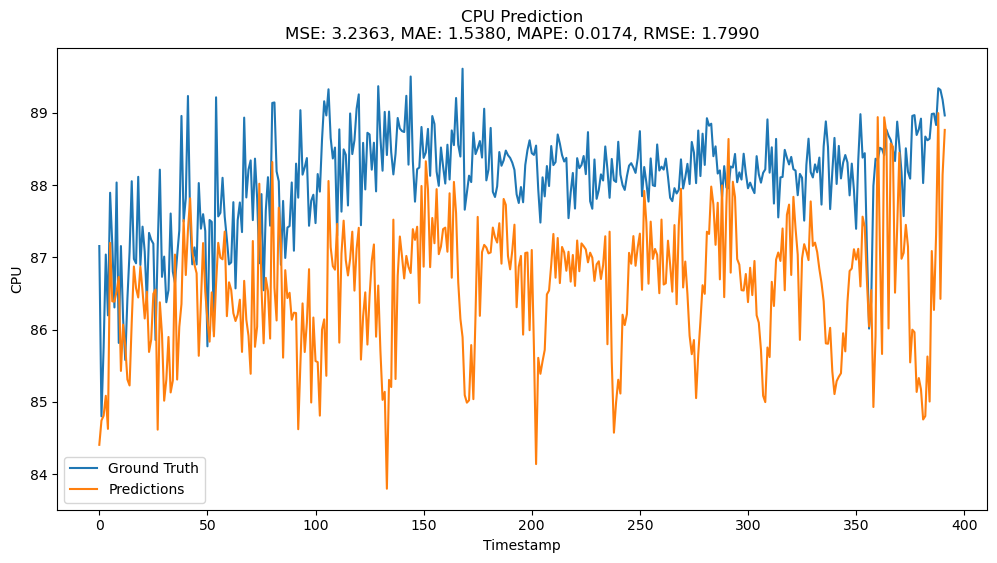

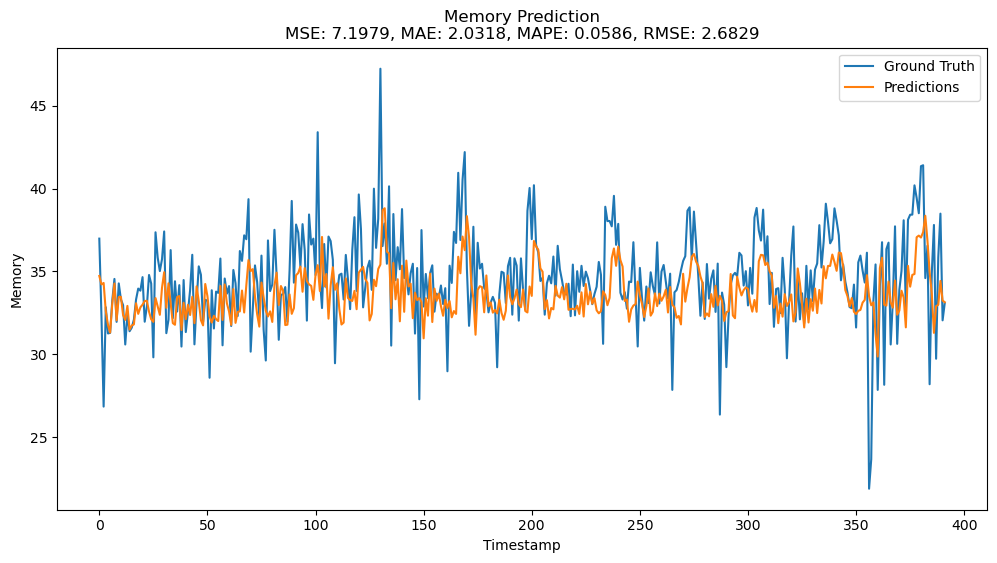

In [24]:
def plot_predictions(y_true, y_pred, df_metrics, target="CPU"):
    """
    Plot the predictions vs ground truth, extracting corresponding evaluation metrics
    for the given target (CPU or Memory) from the metrics DataFrame.
    """
    mse = df_metrics.loc[target, "MSE"]
    mae = df_metrics.loc[target, "MAE"]
    mape = df_metrics.loc[target, "MAPE"]
    rmse = df_metrics.loc[target, "RMSE"]

    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Ground Truth')
    plt.plot(y_pred, label='Predictions')
    plt.xlabel('Timestamp')
    plt.ylabel(target)
    plt.title(f'{target} Prediction\nMSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}, RMSE: {rmse:.4f}')
    plt.legend()
    plt.show()

plot_predictions(y_test_cpu, y_pred_cpu_teacher, df_metrics_teacher, target="CPU")

plot_predictions(y_test_mem, y_pred_mem_teacher, df_metrics_teacher, target="Memory")

# Student Model 

In [25]:
class LighterStudentLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LighterStudentLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        
        # Using GRU instead of LSTM to reduce parameters
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.gru(x)
        
        output = self.fc(output[:,-2:,:]) # 1585,2,1
        return output

hidden_size = 4

input_size = 1
output_size = 1
studentmodel = LighterStudentLSTMModel(input_size, hidden_size, output_size)

student_optimizer = optim.Adam(studentmodel.parameters(), lr=0.001)

studentmodel

LighterStudentLSTMModel(
  (gru): GRU(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
# Train the LSTM model
student_model_trained = train_lstm_model(studentmodel,train_loader, val_loader, input_size=input_size, hidden_size=hidden_size, output_size=input_size, num_epochs=num_epochs)

Epoch [1/500], Train Loss: 0.1181
Epoch [2/500], Train Loss: 0.0698
Epoch [3/500], Train Loss: 0.0378
Epoch [4/500], Train Loss: 0.0274
Epoch [5/500], Train Loss: 0.0266
Epoch [6/500], Train Loss: 0.0262
Epoch [7/500], Train Loss: 0.0260
Epoch [8/500], Train Loss: 0.0256
Epoch [9/500], Train Loss: 0.0252
Epoch [10/500], Train Loss: 0.0248
Epoch [11/500], Train Loss: 0.0244
Epoch [12/500], Train Loss: 0.0239
Epoch [13/500], Train Loss: 0.0235
Epoch [14/500], Train Loss: 0.0230
Epoch [15/500], Train Loss: 0.0224
Epoch [16/500], Train Loss: 0.0219
Epoch [17/500], Train Loss: 0.0213
Epoch [18/500], Train Loss: 0.0206
Epoch [19/500], Train Loss: 0.0201
Epoch [20/500], Train Loss: 0.0193
Epoch [21/500], Train Loss: 0.0186
Epoch [22/500], Train Loss: 0.0180
Epoch [23/500], Train Loss: 0.0172
Epoch [24/500], Train Loss: 0.0166
Epoch [25/500], Train Loss: 0.0161
Epoch [26/500], Train Loss: 0.0156
Epoch [27/500], Train Loss: 0.0153
Epoch [28/500], Train Loss: 0.0152
Epoch [29/500], Train Loss: 0

In [27]:
df_metrics_student, y_test_cpu, y_pred_cpu_student, y_test_mem, y_pred_mem_student = predict_and_evaluate_model(student_model_trained, X_test, y_test, scaler, device)
df_metrics_student

model:  model  	 Size (KB): 2.367


Metric       MSE       MAE      MAPE      RMSE RAM (KB)  \
CPU     3.237917  1.595132  0.018064  1.799421    2.367   
Memory  8.629903  2.279687  0.065199   2.93767    2.367   

Metric Inference Time (seconds)  
CPU                    0.028639  
Memory                 0.028639

In [28]:
def combine_metrics(df_new, model_type, df_combined=None):
    df_new_reset = df_new.reset_index()
    df_new_reset['Model'] = model_type
    df_new_reset.rename(columns={'index': 'Metric'}, inplace=True)  # Rename index column to 'Metric'

    df_new_to_combine = df_new_reset[['Model', 'Metric'] + [col for col in df_new_reset.columns if col not in ['Model', 'Metric']]]

    if df_combined is None:
        combined_df_metrics = df_new_to_combine
    else:
        df_combined_reset = df_combined.reset_index(drop=True)

        combined_df_metrics = pd.concat([df_combined_reset, df_new_to_combine], ignore_index=True)

    combined_df_metrics = combined_df_metrics.loc[:, ~combined_df_metrics.columns.duplicated()]

    return combined_df_metrics
df_metrics_combined = combine_metrics(df_metrics_teacher, 'teacher')
df_metrics_combined = combine_metrics(df_metrics_student, 'student', df_combined=df_metrics_combined)
df_metrics_combined

Metric    Model  Metric       MSE       MAE      MAPE      RMSE RAM (KB)  \
0       teacher     CPU  3.236253  1.537981  0.017423  1.798959   70.783   
1       teacher  Memory   7.19795  2.031842  0.058629  2.682899   70.783   
2       student     CPU  3.237917  1.595132  0.018064  1.799421    2.367   
3       student  Memory  8.629903  2.279687  0.065199   2.93767    2.367   

Metric Inference Time (seconds)  
0                      0.032911  
1                      0.032911  
2                      0.028639  
3                      0.028639

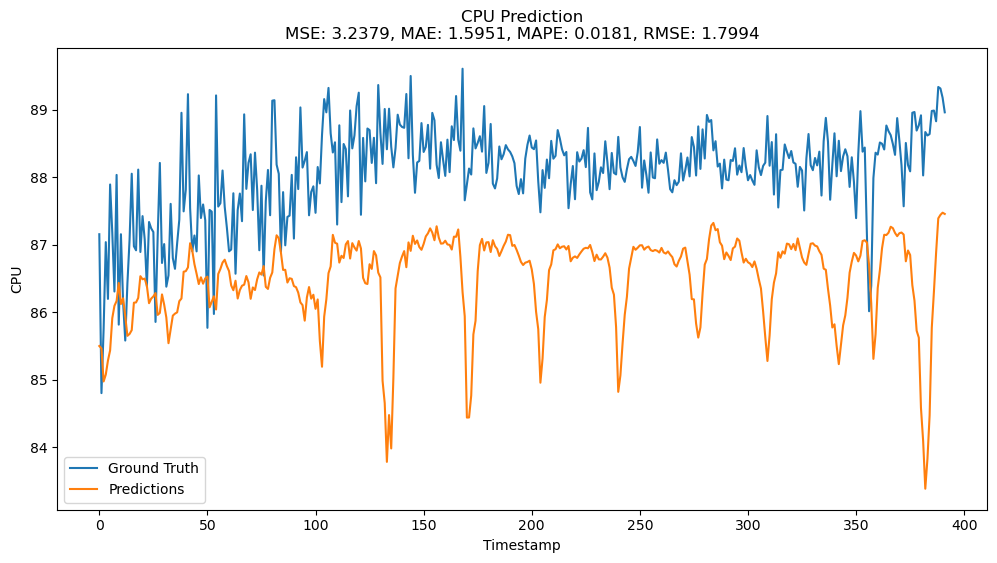

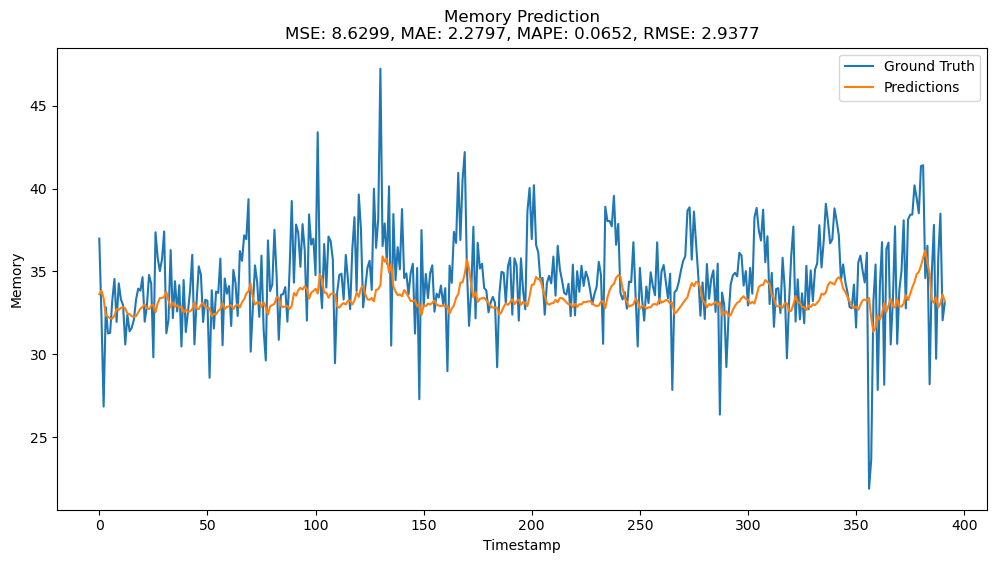

In [29]:
plot_predictions(y_test_cpu, y_pred_cpu_student, df_metrics_student, target="CPU")

plot_predictions(y_test_mem, y_pred_mem_student, df_metrics_student, target="Memory")

# Distilled model

In [30]:
import torch
import torch.nn as nn

def train_knowledge_distillation_regression(teacher, student, train_loader, epochs, T, soft_target_loss_weight, ce_loss_weight, device, optimizer,method):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)

    teacher.eval()  # Set teacher to evaluation mode
    student.train()  # Set student to training mode
    mse_criterion = nn.MSELoss()
    ce_criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # Forward pass
            student_outputs = student(inputs)
            # print(teacher_outputs[1,:], student_outputs[1,:])
            # import pdb;pdb.set_trace()
            # Compute the losses
            if method==1:
                mse_loss = mse_criterion(student_outputs, teacher_outputs)
                loss = mse_loss
            if method==2:
                mse_loss = mse_criterion(student_outputs, teacher_outputs)
                soft_target_loss = ce_criterion(student_outputs / T, teacher_outputs / T) * (T * T)  # Temperature scaling
                # Total loss
                loss = soft_target_loss_weight * soft_target_loss + ce_loss_weight * mse_loss
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

    trained_student_model = student
    return trained_student_model


student_optimizer = optim.Adam(studentmodel.parameters(), lr=0.1)  # Decreased learning rate

studentmodel.to(device)  # Ensure the student model is on the same device as the inputs

# Training call
distilled_student_model = train_knowledge_distillation_regression(
    teacher=teacher_model_trained,
    student=student_model_trained,  # Use the initialized student model
    train_loader=train_loader,
    epochs=50,
    T=2,
    soft_target_loss_weight=0.25,
    ce_loss_weight=0.75,
    device=device,
    optimizer=student_optimizer,
    method = 2
)
df_metrics_distilled, y_test, y_pred_cpu_distilled, y_test_mem, y_pred_mem_distilled = predict_and_evaluate_model(distilled_student_model, X_test, y_test, scaler, device)
df_metrics_distilled

Epoch [10/50], Loss: 0.3479
Epoch [20/50], Loss: 0.3475
Epoch [30/50], Loss: 0.3473
Epoch [40/50], Loss: 0.3474
Epoch [50/50], Loss: 0.3470
model:  model  	 Size (KB): 2.367


Metric       MSE       MAE      MAPE      RMSE RAM (KB)  \
CPU     3.879723  1.582104  0.017915  1.969701    2.367   
Memory  9.977664  2.559002  0.072944  3.158744    2.367   

Metric Inference Time (seconds)  
CPU                    0.006673  
Memory                 0.006673

In [31]:
df_t = combine_metrics(df_metrics_distilled, 'distilled', df_combined=df_metrics_combined)
df_t

Metric      Model  Metric       MSE       MAE      MAPE      RMSE RAM (KB)  \
0         teacher     CPU  3.236253  1.537981  0.017423  1.798959   70.783   
1         teacher  Memory   7.19795  2.031842  0.058629  2.682899   70.783   
2         student     CPU  3.237917  1.595132  0.018064  1.799421    2.367   
3         student  Memory  8.629903  2.279687  0.065199   2.93767    2.367   
4       distilled     CPU  3.879723  1.582104  0.017915  1.969701    2.367   
5       distilled  Memory  9.977664  2.559002  0.072944  3.158744    2.367   

Metric Inference Time (seconds)  
0                      0.032911  
1                      0.032911  
2                      0.028639  
3                      0.028639  
4                      0.006673  
5                      0.006673

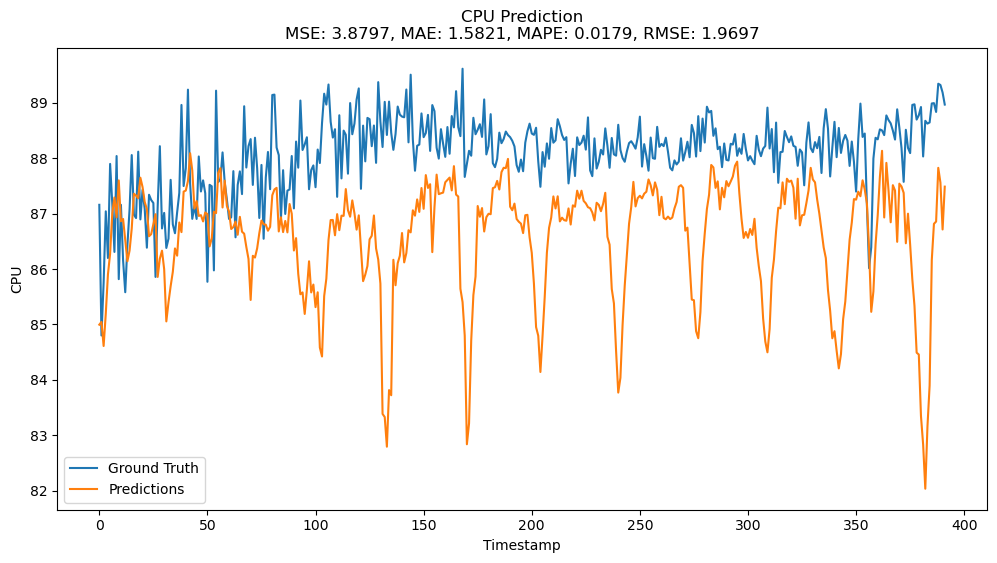

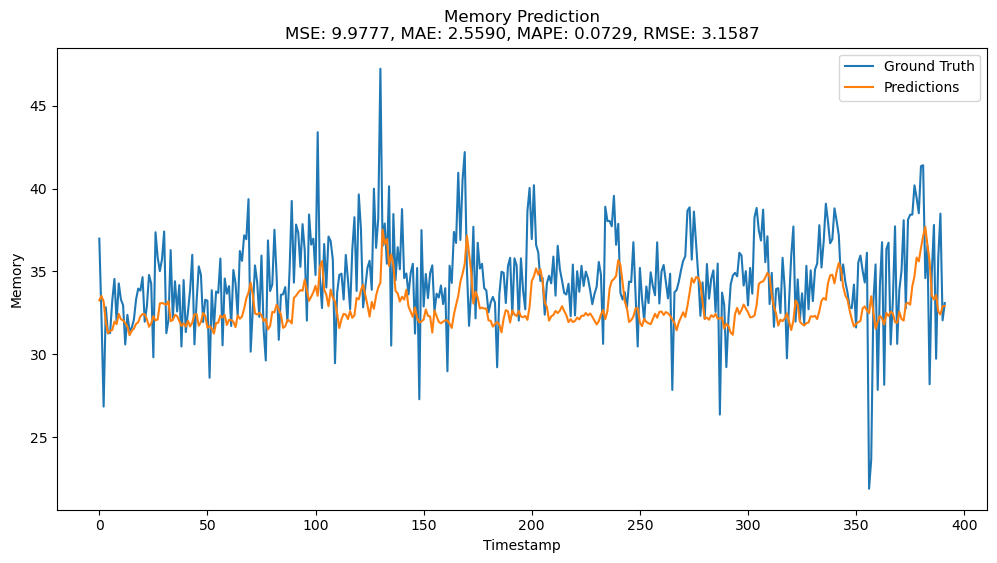

In [32]:
plot_predictions(y_test_cpu, y_pred_cpu_distilled, df_metrics_distilled, target="CPU")

plot_predictions(y_test_mem, y_pred_mem_distilled, df_metrics_distilled, target="Memory")

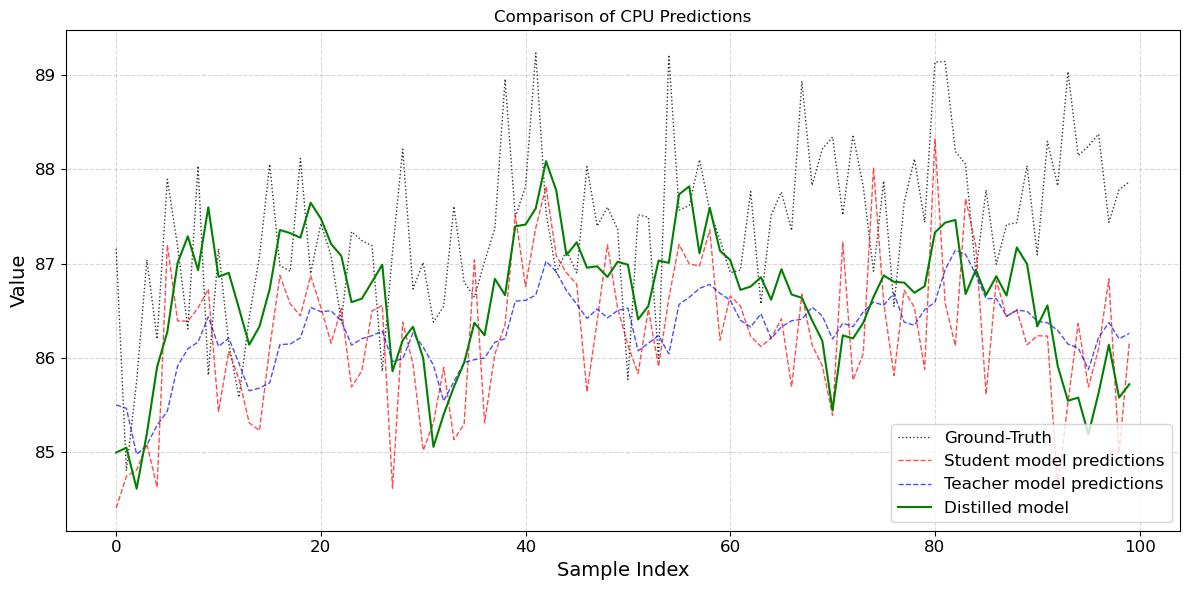

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use('default')

def plot_predictions(y_test, y_pred1, y_pred2, y_pred3, label_pred1, label_pred2, label_pred3, title, name_pdf):
    with PdfPages(name_pdf) as pdf:
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, label='Ground-Truth', color='black', linestyle=':', linewidth=1, alpha=0.8)
        plt.plot(y_pred1, label=label_pred1, color='red', linestyle='--', linewidth=1, alpha=0.7)
        plt.plot(y_pred2, label=label_pred2, color='blue', linestyle='--', linewidth=1, alpha=0.7)
        plt.plot(y_pred3, label=label_pred3, color='green', linestyle='-', linewidth=1.5, alpha=1)
        plt.title(title, fontsize=12)
        plt.xlabel('Sample Index', fontsize=14)
        plt.ylabel('Value', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(fontsize=12, loc='lower right')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        pdf.savefig()
        plt.show()

plot_predictions(
    y_test_cpu[:100], 
    y_pred_cpu_teacher[:100], 
    y_pred_cpu_student[:100], 
    y_pred_cpu_distilled[:100],
    label_pred2='Teacher model predictions', 
    label_pred1='Student model predictions', 
    label_pred3='Distilled model', 
    title='Comparison of CPU Predictions', 
    name_pdf="distilled_cpu_model.pdf"
)

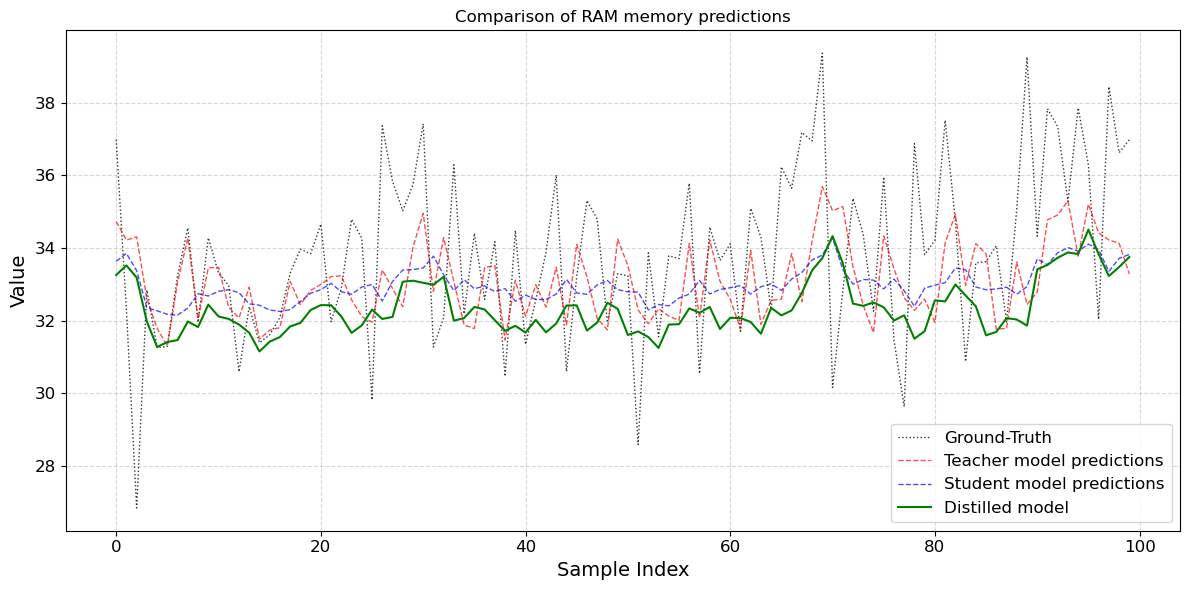

In [55]:
plot_predictions(
    y_test_mem[:100], 
    y_pred_mem_teacher[:100], 
    y_pred_mem_student[:100], 
    y_pred_mem_distilled[:100],
    label_pred1='Teacher model predictions', 
    label_pred2='Student model predictions', 
    label_pred3='Distilled model', 
    title='Comparison of RAM memory predictions', 
    name_pdf="distilled_mem_model.pdf"
)

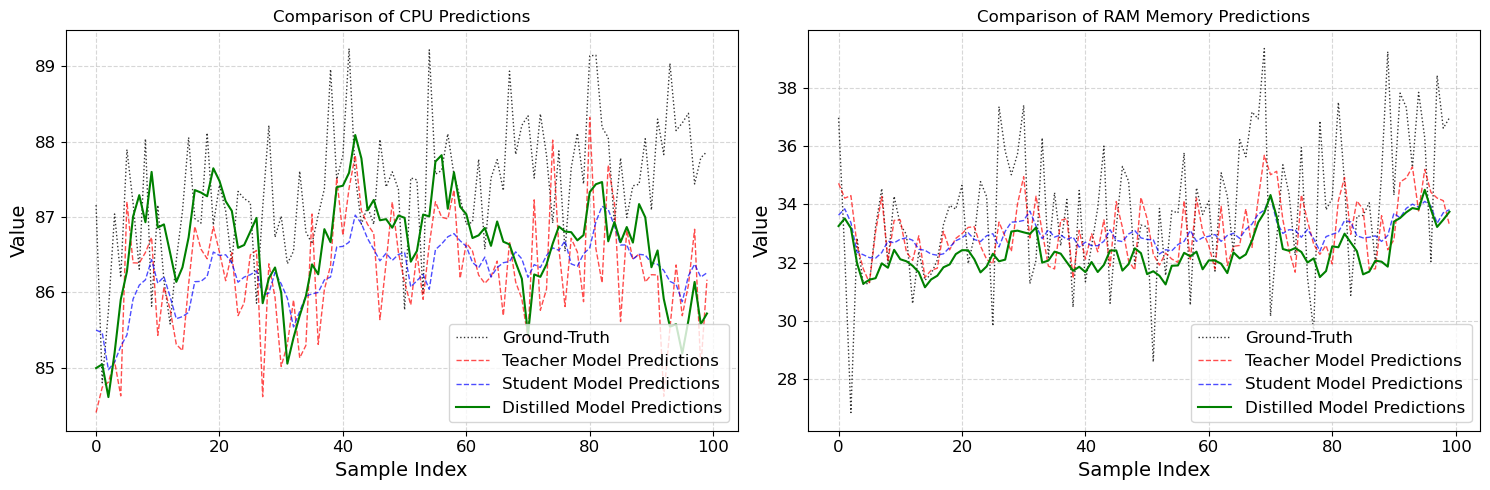

In [57]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def plot_predictions(y_test_cpu, y_pred_cpu_teacher, y_pred_cpu_student, y_pred_cpu_distilled,
                    y_test_mem, y_pred_mem_teacher, y_pred_mem_student, y_pred_mem_distilled,
                    name_pdf):
    with PdfPages(name_pdf) as pdf:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a figure with 1 row and 2 columns
        
        # Plotting CPU Predictions
        axs[0].plot(y_test_cpu, label='Ground-Truth', color='black', linestyle=':', linewidth=1, alpha=0.8)
        axs[0].plot(y_pred_cpu_teacher, label='Teacher Model Predictions', color='red', linestyle='--', linewidth=1, alpha=0.7)
        axs[0].plot(y_pred_cpu_student, label='Student Model Predictions', color='blue', linestyle='--', linewidth=1, alpha=0.7)
        axs[0].plot(y_pred_cpu_distilled, label='Distilled Model Predictions', color='green', linestyle='-', linewidth=1.5, alpha=1)
        axs[0].set_title('Comparison of CPU Predictions', fontsize=12)
        axs[0].set_xlabel('Sample Index', fontsize=14)
        axs[0].set_ylabel('Value', fontsize=14)
        axs[0].grid(True, linestyle='--', alpha=0.5)
        axs[0].legend(fontsize=12, loc='lower right')
        axs[0].tick_params(axis='both', labelsize=12)

        # Plotting Memory Predictions
        axs[1].plot(y_test_mem, label='Ground-Truth', color='black', linestyle=':', linewidth=1, alpha=0.8)
        axs[1].plot(y_pred_mem_teacher, label='Teacher Model Predictions', color='red', linestyle='--', linewidth=1, alpha=0.7)
        axs[1].plot(y_pred_mem_student, label='Student Model Predictions', color='blue', linestyle='--', linewidth=1, alpha=0.7)
        axs[1].plot(y_pred_mem_distilled, label='Distilled Model Predictions', color='green', linestyle='-', linewidth=1.5, alpha=1)
        axs[1].set_title('Comparison of RAM Memory Predictions', fontsize=12)
        axs[1].set_xlabel('Sample Index', fontsize=14)
        axs[1].set_ylabel('Value', fontsize=14)
        axs[1].grid(True, linestyle='--', alpha=0.5)
        axs[1].legend(fontsize=12, loc='lower right')
        axs[1].tick_params(axis='both', labelsize=12)

        plt.tight_layout()
        pdf.savefig(fig)
        plt.show()

# Call the function for CPU and Memory predictions
plot_predictions(
    y_test_cpu[:100], 
    y_pred_cpu_teacher[:100], 
    y_pred_cpu_student[:100], 
    y_pred_cpu_distilled[:100],
    y_test_mem[:100], 
    y_pred_mem_teacher[:100], 
    y_pred_mem_student[:100], 
    y_pred_mem_distilled[:100],
    name_pdf="distilled_model_comparison.pdf"
)